# seasonを抜いた最適パラメータで学習

In [2]:
import numpy as np
import pandas as pd

In [3]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [4]:
#ls

In [5]:
#cd ./drive/MyDrive/

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [7]:
test_df = pd.read_csv("./input/test.csv")
train_df = pd.read_csv("./input/train.csv")

In [8]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [9]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [11]:
#データタイム型を年、月、週、時間に分割する
train_df['datetime_original'] = pd.to_datetime(train_df['datetime'])

train_df['year']=pd.DatetimeIndex(train_df['datetime_original']).year
train_df['month']=pd.DatetimeIndex(train_df['datetime_original']).month
train_df['weekday']=pd.DatetimeIndex(train_df['datetime_original']).weekday
train_df['hour']=pd.DatetimeIndex(train_df['datetime_original']).hour

In [12]:
#変換できているか確認
train_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_original,year,month,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,1,5,0


In [13]:
#データタイム型を年、月、週、時間に分割する
test_df['datetime_original'] = pd.to_datetime(test_df['datetime'])

test_df['year']=pd.DatetimeIndex(test_df['datetime_original']).year
test_df['month']=pd.DatetimeIndex(test_df['datetime_original']).month
test_df['weekday']=pd.DatetimeIndex(test_df['datetime_original']).weekday
test_df['hour']=pd.DatetimeIndex(test_df['datetime_original']).hour

In [14]:
test_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime_original,year,month,weekday,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,2011,1,3,0


In [15]:
#学習データの整形
df_y = train_df['count']
df_X = train_df.drop(['datetime','season','casual','registered','count','datetime_original'],axis=1)

In [16]:
df_y = df_y.astype(int)
df_X = df_X.astype(int)

In [17]:
df_y.head(3)

0    16
1    40
2    32
Name: count, dtype: int32

In [18]:
df_X.head(3)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour
0,0,0,1,9,14,81,0,2011,1,5,0
1,0,0,1,9,13,80,0,2011,1,5,1
2,0,0,1,9,13,80,0,2011,1,5,2


In [19]:
#sklearnとxgboostをインポート
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [20]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True)

In [21]:
#xgboostようにデータを整形
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [22]:
%%time
params ={'max_depth':10,
            'min_child_weight':3,
            'gamma':0.4,
            'subsample':0.9,
            'colsample_bytree':1,
            'reg_alpha':100,
            'n_estimators':1000,
            'reg_lambda':0.1,
            'learning_rate':0.1,
            "objective" : "reg:squarederror",
            "eval_metric" : "rmsle"
            }
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dtest, "valid")],
    num_boost_round = 100,
    early_stopping_rounds=50,
)
"""
model = xgb.XGBRegressor(silent=False,n_jobs=-1)
model_grid = GridSearchCV(model, cv_params, cv=5, n_jobs=-1)
model_grid.fit(X_train,
                y_train,
                early_stopping_rounds=50,
                eval_set=[(X_test, y_test)],
                eval_metric='rmsle',
                verbose=0)
print('optimal_parameters\n', model_grid.best_params_)
"""

[22:30:00] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.09796	valid-rmsle:2.10355
[1]	train-rmsle:1.55134	valid-rmsle:1.55080
[2]	train-rmsle:1.23994	valid-rmsle:1.24067
[3]	train-rmsle:1.02844	valid-rmsle:1.03045
[4]	train-rmsle:0.87524	valid-rmsle:0.88208
[5]	train-rmsle:0.75599	valid-rmsle:0.76494
[6]	train-rmsle:0.66282	valid-rmsle:0.67701
[7]	train-rmsle:0.58815	valid-rmsle:0.60535
[8]	train-rmsle:0.52807	valid-rmsle:0.54695
[9]	train-rmsle:0.47820	valid-rmsle:0.50006
[10]	train-rmsle:0.43626	valid-rmsle:0.46195
[11]	train-rmsle:0.40161	valid-rmsle:0.43154
[12]	train-rmsle:0.37412	valid-rmsle:0.40765
[13]	train-rmsle:0.35038	valid-rmsle:0.38724
[14]	train-rmsle:0.33148	valid-rmsle:0.37172
[15

"\nmodel = xgb.XGBRegressor(silent=False,n_jobs=-1)\nmodel_grid = GridSearchCV(model, cv_params, cv=5, n_jobs=-1)\nmodel_grid.fit(X_train,\n                y_train,\n                early_stopping_rounds=50,\n                eval_set=[(X_test, y_test)],\n                eval_metric='rmsle',\n                verbose=0)\nprint('optimal_parameters\n', model_grid.best_params_)\n"

In [23]:
#予測
y_pred_train = model.predict(xgb.DMatrix(X_train))
y_pred_test = model.predict(xgb.DMatrix(X_test))

In [24]:
y_pred_train = y_pred_train.astype(int)
y_pred_train[y_pred_train<0] = 0
y_pred_test = y_pred_test.astype(int)
y_pred_test[y_pred_test<0] = 0

In [25]:
# 学習モデルの評価（RMSEを計算）
from sklearn.metrics import mean_squared_log_error
print('RMSE(train data):',round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print('RMSLE(train data):',round(np.sqrt(mean_squared_log_error(y_train, y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print('RMSLE(test data):',round(np.sqrt(mean_squared_log_error(y_test, y_pred_test)),3))

RMSE(train data): 15.804
RMSLE(train data): 0.202
RMSE(test data): 35.436
RMSLE(test data): 0.306


In [26]:
visu_df = pd.DataFrame([y_pred_train,y_train], index = ['y_pred','y'])
visu_df = visu_df.T
visu_df

,y_pred,y
0,112,111
1,129,144
2,263,279
3,216,201
4,393,417
...,...,...
8703,49,59
8704,68,66
8705,182,175
8706,7,5


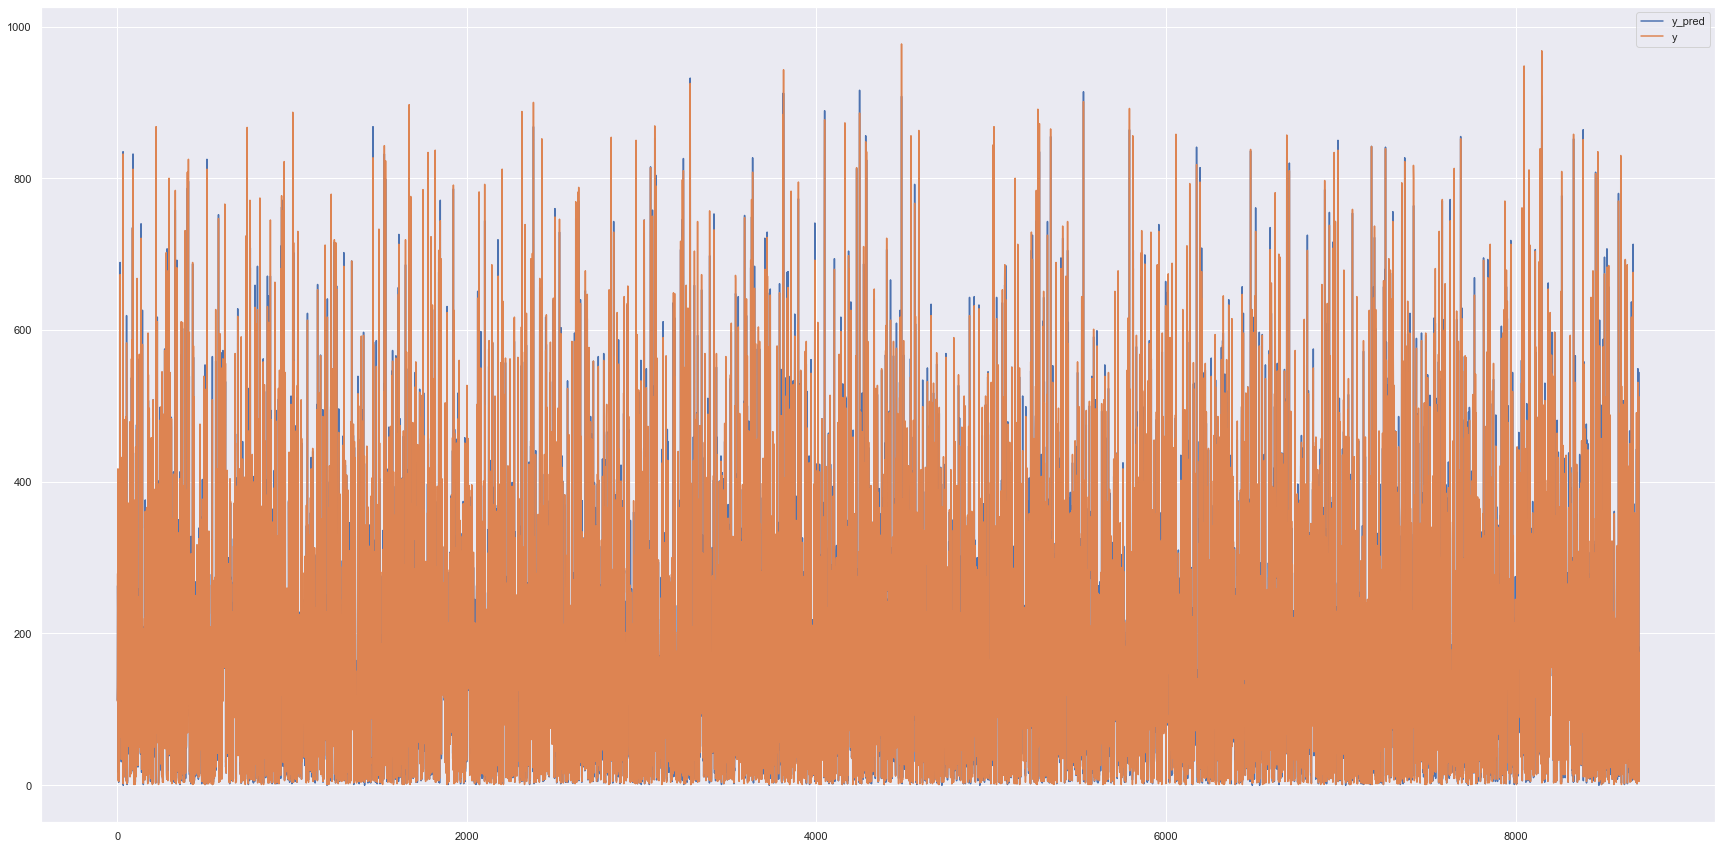

In [27]:
plt.rcParams["figure.figsize"] = (30,15)
visu_df.plot()
plt.show()

In [28]:
dif = y_pred_test-y_test
print(dif.sum())
print(f'y > y_pred の個数:  {len(dif[dif <0])}')
print(f'y = y_pred の個数:  {len(dif[dif ==0])}')
print(f'y < y_pred の個数:  {len(dif[dif >0])}')


-634
y > y_pred の個数:  1029
y = y_pred の個数:  68
y < y_pred の個数:  1081


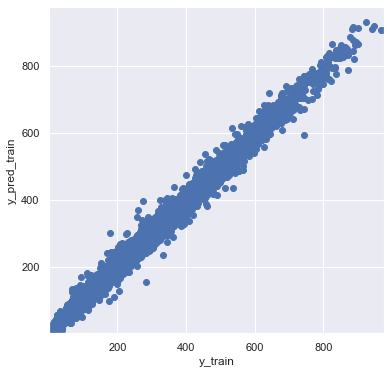

In [29]:
# グラフエリアを設定し、散布図を描く。
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred_train)

# yの最大値、最小値を計算する。
y_max = np.max(y_train)
y_min = np.min(y_train)

# predict_yの最大値、最小値を計算する。
predict_y_max = np.max(y_pred_train)
predict_y_min = np.min(y_train)

# 全てのプロットが収まるようにするには、yとpredict_y両方のうち
# 最も小さい値、最も大きい値を縦軸横軸の範囲にすればいい。
axis_max = max(y_max, predict_y_max)
axis_min = min(y_min, predict_y_min)

plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)

plt.xlabel('y_train')
plt.ylabel('y_pred_train')

plt.show()

In [30]:
test_df = test_df.drop(['datetime','season','datetime_original'],axis=1)
test_df = test_df.astype(int)

In [31]:
#実際のtestデータの予測を作成
pred_test = model.predict(xgb.DMatrix(test_df))

In [32]:
sub = pd.read_csv('./input/sampleSubmission.csv')
pred_test = pred_test.astype(int)
pred_test[pred_test<0] = 0
sub['count']=pred_test

sub.head(125)

,datetime,count
0,2011-01-20 00:00:00,13
1,2011-01-20 01:00:00,4
2,2011-01-20 02:00:00,2
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,3
...,...,...
120,2011-01-25 04:00:00,2
121,2011-01-25 05:00:00,4
122,2011-01-25 06:00:00,33
123,2011-01-25 07:00:00,74


In [33]:
sub.to_csv('Subm_1.csv', index=False)
"""
from google.colab import files
files.download('Subm_1.csv') 
"""
"""1回目　Score 0.53463
   2回目  Score 0.52750
   3回目  Score 0.60054
   4回目  Score 0.64267
   5回目  Score 0.67732
   """

'1回目\u3000Score 0.53463\n   2回目  Score 0.52750\n   3回目  Score 0.60054\n   4回目  Score 0.64267\n   5回目  Score 0.67732\n   '

[Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'weather vs Count')]

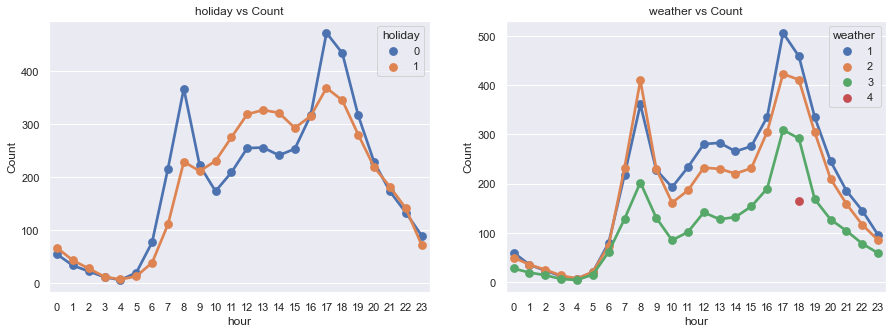

In [34]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 5)
hourholiday = pd.DataFrame(train_df.groupby(["hour","holiday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourholiday["hour"], y=hourholiday["count"],hue=hourholiday["holiday"], data=hourholiday, join=True, ax=axes[0])
hourweather = pd.DataFrame(train_df.groupby(["hour","weather"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourweather["hour"], y=hourweather["count"],hue=hourweather["weather"], data=hourweather, join=True, ax=axes[1])

axes[0].set(xlabel='hour', ylabel='Count',title="holiday vs Count")
axes[1].set(xlabel='hour', ylabel='Count',title="weather vs Count")

[Text(0.5, 0, 'hour'), Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'month vs Count')]

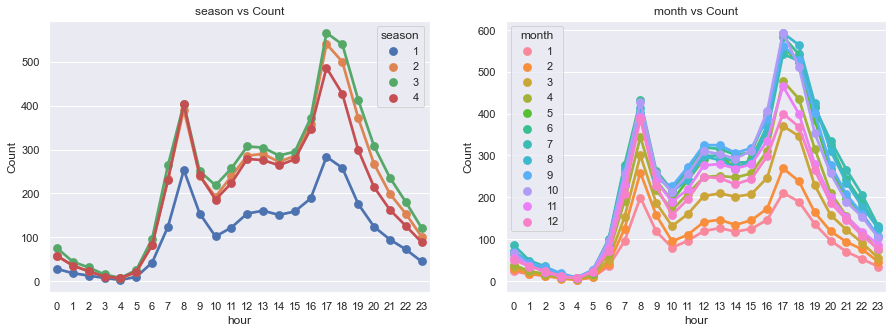

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 5)
hourseason = pd.DataFrame(train_df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourseason["hour"], y=hourseason["count"],hue=hourseason["season"], data=hourseason, join=True, ax=axes[0])
hourmonth = pd.DataFrame(train_df.groupby(["hour","month"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourmonth["hour"], y=hourmonth["count"],hue=hourmonth["month"], data=hourmonth, join=True, ax=axes[1])

axes[0].set(xlabel='hour', ylabel='Count',title="season vs Count")
axes[1].set(xlabel='hour', ylabel='Count',title="month vs Count")

[Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'workingday vs Count')]

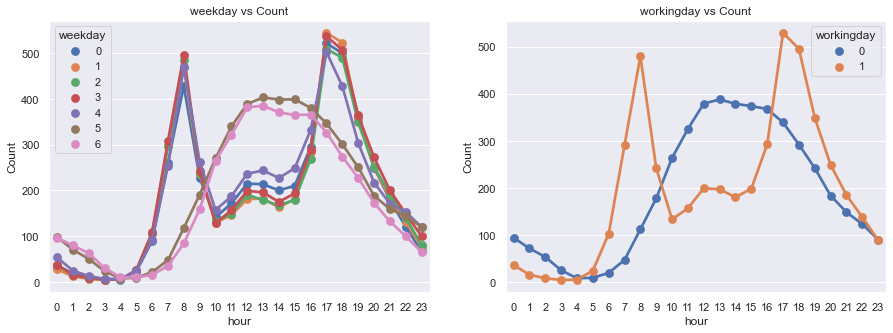

In [36]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 5)
hourweekday = pd.DataFrame(train_df).groupby(["hour","weekday"],sort=True)["count"].mean().reset_index()
sns.pointplot(x=hourweekday["hour"], y=hourweekday["count"],hue=hourweekday["weekday"], data=hourweekday, join=True, ax=axes[0])
hourworkingday = pd.DataFrame(train_df).groupby(["hour","workingday"],sort=True)["count"].mean().reset_index()
sns.pointplot(x=hourworkingday["hour"], y=hourworkingday["count"],hue=hourworkingday["workingday"], data=hourworkingday, join=True, ax=axes[1])

axes[0].set(xlabel='hour', ylabel='Count',title="weekday vs Count")
axes[1].set(xlabel='hour', ylabel='Count',title="workingday vs Count")

In [37]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold, learning_curve
from sklearn.metrics import mean_squared_log_error as msle
from datetime import datetime

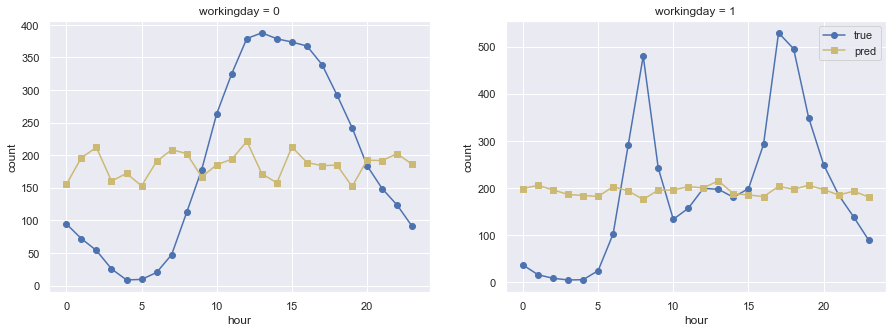

In [38]:
"""#１０分割の交差検証。それぞれで時間ごとの平均をとり、グラフにしてみる
kf = KFold(n_splits=10, shuffle=True, random_state=1).split(X_train, y_train)
kf_ = list(kf)

for train, valid in kf_:
  #ここから学習と予測
  model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dtest, "valid")],
    num_boost_round = 50,
    early_stopping_rounds=50,
  )
  #予測
  prediction = model.predict(xgb.DMatrix(train))
  
  prediction =prediction.astype(int)
  prediction[prediction < 0] = 0
  y_true = y_train.loc[valid]
  """
#ここからグラフの制作
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax_ = fig.add_subplot(122)
#検証用データ（実際の値）と予測値について時間ごと平均をとっている
count_hour_true = pd.DataFrame(train_df.groupby(["hour","workingday"],sort=True)["count"].mean()).reset_index()
preds = pd.concat([train_df.reset_index(), pd.Series(y_pred_train , name="count_pred").reset_index()], axis=1)
count_hour_pred = pd.DataFrame(preds.groupby(["hour", "workingday"], sort=True)["count_pred"].mean()).reset_index()
#workingdayの値ごとに変数に代入している
count_workingday_0_true = count_hour_true[count_hour_true["workingday"] == 0]
count_workingday_1_true = count_hour_true[count_hour_true["workingday"] == 1]
count_workingday_0_pred = count_hour_pred[count_hour_pred["workingday"] == 0]
count_workingday_1_pred = count_hour_pred[count_hour_pred["workingday"] == 1]
#グラフにプロット
ax.plot(count_workingday_0_true["hour"], count_workingday_0_true["count"], label="true", color="b", marker="o")
ax.plot(count_workingday_0_true["hour"], count_workingday_0_pred["count_pred"], label="pred", color="y", marker="s")
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.set_title("workingday = 0")
ax_.plot(count_workingday_1_true["hour"], count_workingday_1_true["count"], label = "true", color="b",marker="o")
ax_.plot(count_workingday_1_pred["hour"], count_workingday_1_pred["count_pred"], label="pred", color="y", marker="s")
ax_.set_xlabel("hour")
ax_.set_ylabel("count")
ax_.set_title("workingday = 1")
plt.legend()